#### Setup

In [1]:
from qiskit_transpiler import get_pm
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_provider import IBMProvider
from qiskit_experiments.library import InterleavedRB
import qiskit.circuit.library as circuits
from qiskit import QuantumCircuit

In [2]:
#Setting the IBM provider
api_file = "../../../ibm_API_key"
with open(api_file, "r") as f:
        api_key = f.readline().strip()
provider = IBMProvider(api_key, instance='ibm-q-ncsu/nc-state/quantum-compiler')
backend = provider.get_backend('ibm_kyoto')

#### Circuit to only pass as a gate

In [3]:
gate_circuit = QuantumCircuit(1, name='custom_rx')
gate_circuit.rx(np.pi/2,0)
custom_rx = gate_circuit.to_gate()

#### Circuit to pass for getting the calibration specific to the qubit

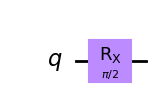

In [4]:
calibration_circuit = QuantumCircuit(1)
calibration_circuit.rx(np.pi/2,0)
calibration_circuit.draw('mpl')

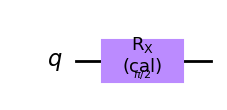

In [5]:
pm = get_pm(backend)
calibrated_circuit = pm.run(calibration_circuit)
calibrated_circuit.draw('mpl')

In [6]:
calibrated_circuit.calibrations

{'rx': {((0,),
   (1.5707963267948966,)): ScheduleBlock(Play(Drag(duration=120, sigma=30, beta=0.2155373364611679, amp=0.09941018780096071, angle=0), DriveChannel(0)), name="rx(1.571)", transform=AlignLeft())}}

In [7]:
calibration = list(calibrated_circuit.calibrations['rx'].values())[0]

In [8]:
backend.target.add_instruction(custom_rx, {(0,): InstructionProperties(calibration=calibration)})

In [9]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [0] # make sure it is the qubit added in the backend target

int_exp = InterleavedRB(
    custom_rx, qubits, lengths, num_samples=num_samples, seed=seed, backend=backend)

In [10]:
int_expdata = int_exp.run(backend).block_for_results()
int_results = int_expdata.analysis_results()

In [ ]:
# View result data
display(int_expdata.figure(0))
for result in int_results:
    print(result)

In [ ]:
int_exp.circuits()[1].draw(output='mpl')

In [ ]:
# you can see that the transpiled circuits contain the calibrations
int_exp._transpiled_circuits()[1].draw(output='mpl')